In [1]:
from silab.utils import pred_accuracy, split_pred_accuracy 
from silab.convarchs import simple_CNN, MLP, DANN, RDANN
from silab.TDDAdata import TDDA_loader
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.io as sio
import os
import numpy as np
import pandas as pd
from torch.utils.data import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)

In [3]:
PATH = 'L:/vibnet-hankooktire/TDDA_dataset/npy_data/'

## Data loading

In [4]:
tdda = TDDA_loader(PATH, split=0.8)

In [5]:
tdda = TDDA_loader(PATH, split=0.80, rpm_flag = True, rpm_labels = [750,1000])

In [6]:
a1 = np.load(f'{PATH}750_rpm.npy')
a2 = np.load(f'{PATH}1000_rpm.npy')
#a3 = np.load(f'{PATH}1200_rpm.npy')
#a4 = np.load(f'{PATH}1600_rpm.npy')

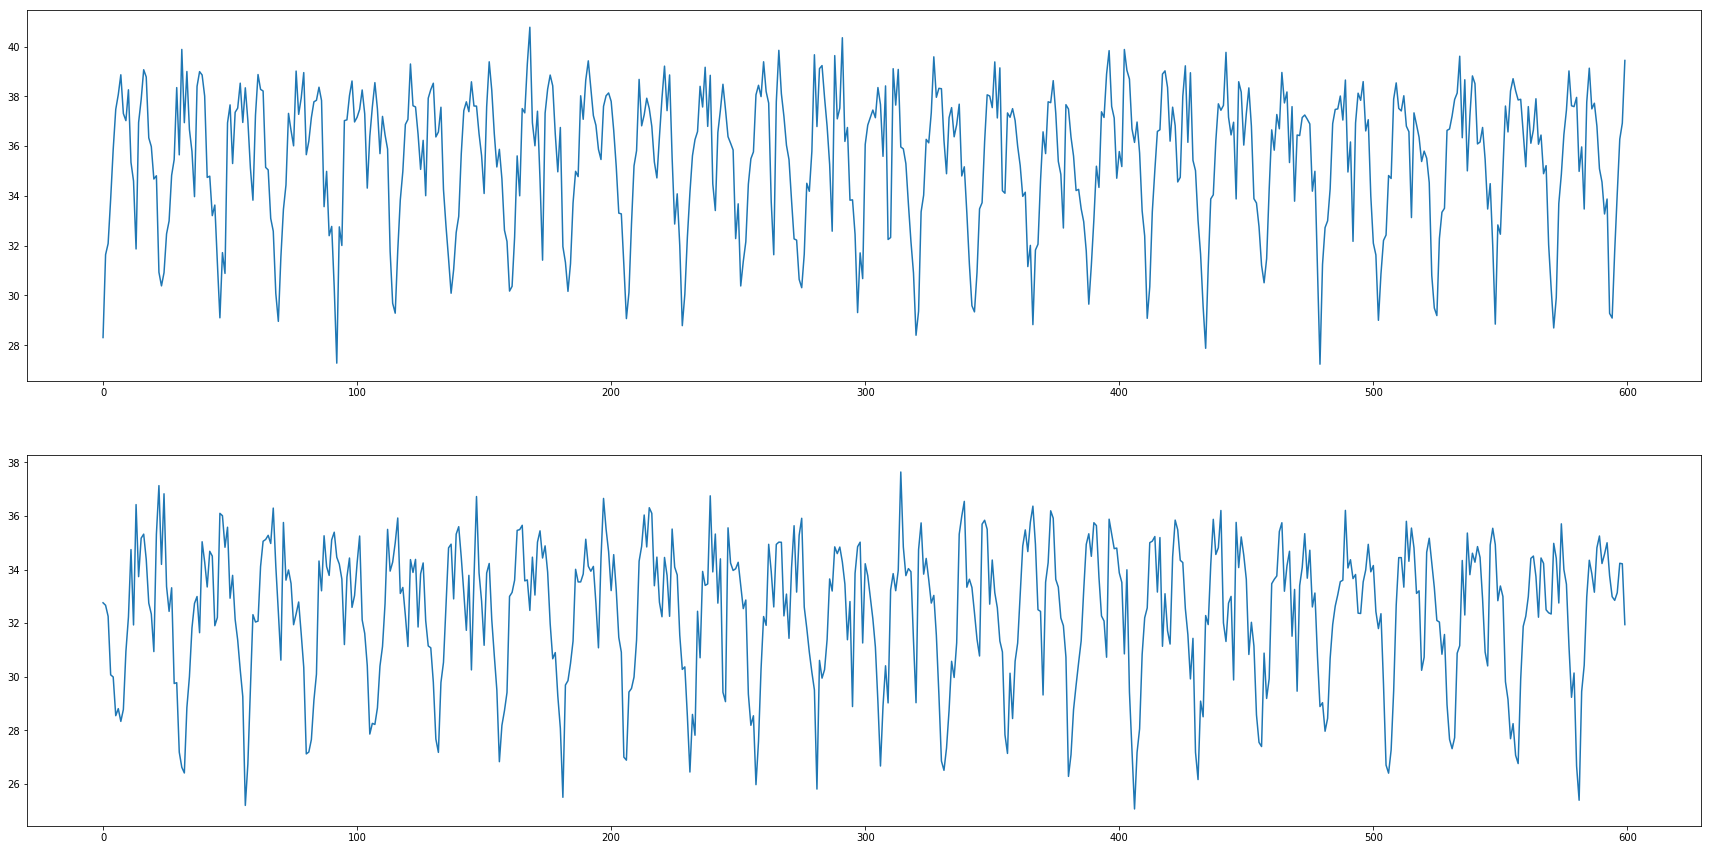

In [6]:
fig = plt.figure(figsize=(30,15))
fig.add_subplot(2,1,1)
plt.plot(a1[201,:][800:1400])
fig.add_subplot(2,1,2)
plt.plot(a2[601,:][800:1400])
#fig.add_subplot(4,1,3)
#plt.plot(a3[1,:][800:1400])
#fig.add_subplot(4,1,4)
#plt.plot(a4[1,:][800:1400])

In [29]:
train, test = tdda.getDataLoader()

Number of examples in train and test dataloaders: train = 3200, test = 800.
Source, target domain data points in train dataloader: 1279, 1921; test dataloader: 321, 479.


In [30]:
srtrain, srtest, trtrain, trtest = tdda.getSplitDataLoader()

Number of examples in source domain train and test dataloaders: train = 1280, test = 320.
Number of examples in target domain train and test dataloaders: train = 1920, test = 480.


### Simple CNN test

Baseline test: supervised training with labels from all domain available

In [5]:
train, test = tdda.getDataLoader()

Number of examples in train and test dataloaders: train = 1920, test = 480.
Source, target domain data points in train dataloader: 1281, 639; test dataloader: 319, 161.


In [6]:
m = simple_CNN([1,3,6],[1758,4])

In [7]:
opt = torch.optim.Adam(m.parameters(), weight_decay= 0.0015, lr=0.001)
for epoch in range(2):
    run_loss = 0
    count = 0 
    for i, data in enumerate(train):
        x, y, domain_label = data
        opt.zero_grad()       
        y_hat = m(x)
        loss = F.nll_loss(y_hat,y)
        # if sample comes from target and not source ignore the loss
        if domain_label == 0:
            count += 1
        loss.backward()
        opt.step()
        run_loss += loss.item()
        if i % 1000 == 0 and i != 0:
            print('Loss: {}'.format(run_loss/(i)))
            print('Train accuracy on source domain: {}'.format(pred_accuracy(m, train, len(train)), False,True))
            print('Train accuracy on target domains (different rpm): {}'.format(pred_accuracy(m, train, len(train),True,False)))
            print('Test accuracy on source domain: {}'.format(pred_accuracy(m, test, len(test),False,True))) 
            print('Test accuracy on target domains (different rpm): {}'.format(pred_accuracy(m, test, len(test),True,False)))
            print('Train accuracy on all: {}'.format(pred_accuracy(m, train, len(train),True,True))) 
            print('Test accuracy on all: {}'.format(pred_accuracy(m, test, len(test),True,True)))

Loss: 0.4877838517725468
Train accuracy on source domain: 1.0
Train accuracy on target domains (different rpm): 1.0
Test accuracy on source domain: 1.0
Test accuracy on target domains (different rpm): 1.0
Train accuracy on all: 1.0
Test accuracy on all: 1.0
Loss: 0.0008612812757492065
Train accuracy on source domain: 1.0
Train accuracy on target domains (different rpm): 1.0
Test accuracy on source domain: 1.0
Test accuracy on target domains (different rpm): 1.0
Train accuracy on all: 1.0
Test accuracy on all: 1.0


### DA CNN test

In [10]:
train, test = tdda.getDataLoader()

Number of examples in train and test dataloaders: train = 1920, test = 480.
Source, target domain data points in train dataloader: 1291, 629; test dataloader: 309, 171.


In [11]:
m = simple_CNN([1,3,6],[1758,4])

In [12]:
opt = torch.optim.Adam(m.parameters(), weight_decay= 0.0015, lr=0.001)
for epoch in range(2):
    run_loss = 0
    count = 0 
    for i, data in enumerate(train):
        x, y, domain_label = data
        opt.zero_grad()       
        y_hat = m(x)
        loss = F.nll_loss(y_hat,y)
        # if sample comes from target and not source ignore the loss
        if domain_label == 0:
            count += 1
        else:
            loss.backward()
            opt.step()
            run_loss += loss.item()
        if i % 1000 == 0 and i != 0:
            print('Loss: {}'.format(run_loss/(i-count)))
            print('Train accuracy on source domain: {}'.format(pred_accuracy(m, train, len(train)), False,True))
            print('Train accuracy on target domains (different rpm): {}'.format(pred_accuracy(m, train, len(train),True,False)))
            print('Test accuracy on source domain: {}'.format(pred_accuracy(m, test, len(test),False,True))) 
            print('Test accuracy on target domains (different rpm): {}'.format(pred_accuracy(m, test, len(test),True,False)))
            print('Train accuracy on all: {}'.format(pred_accuracy(m, train, len(train),True,True))) 
            print('Test accuracy on all: {}'.format(pred_accuracy(m, test, len(test),True,True)))

Loss: 0.058145974880705276
Train accuracy on source domain: 1.0
Train accuracy on target domains (different rpm): 0.24006359300476948
Test accuracy on source domain: 1.0
Test accuracy on target domains (different rpm): 0.28654970760233917
Train accuracy on all: 0.7510416666666667
Test accuracy on all: 0.7458333333333333
Loss: 3.1675807206916276e-05
Train accuracy on source domain: 1.0
Train accuracy on target domains (different rpm): 0.24006359300476948
Test accuracy on source domain: 1.0
Test accuracy on target domains (different rpm): 0.28654970760233917
Train accuracy on all: 0.7510416666666667
Test accuracy on all: 0.7458333333333333


## DANN - 2 domains 

Experiment with two domains only: 750 and 1000

Observations: 
1. If latent vector is not big enough, training troubles!
2. Avoid dropout or too many layers after the architectural split into label disciminator and domain discriminator: otherwise, training troubles!

In [35]:
tdda = TDDA_loader(PATH, split=0.7)
srtrain, srtest, trtrain, trtest = tdda.getSplitDataLoader()

Number of examples in source domain train and test dataloaders: train = 1280, test = 320.
Number of examples in target domain train and test dataloaders: train = 640, test = 160.


In [36]:
m1 = simple_CNN([1,3,6,12],[1704,1704])
m2 = simple_CNN([1],[1704,4])
m3 = simple_CNN([1],[1704,2],smax_l = False)

In [37]:
m = DANN(m1,m2,m3)

In [38]:
opt = torch.optim.Adam(m.parameters(), weight_decay= 0.000, lr=0.001)

In [39]:
m.domain_fit(optimizer = opt, epochs = 1, sourceTrain = srtrain, sourceTest = srtest, targetTrain = trtrain,\
             targetTest = trtest, every_iter=500, dom_reg_l=[3])

Label loss: 0.0, domain loss (source): 0.0, domain loss (target): 1.0
Train accuracy on source domain: 1.0
Train accuracy on target domains (different rpm): 0.4890625
Test accuracy on source domain: 1.0
Test accuracy on target domains (different rpm): 0.50625


### DANN - 3 domains

Experiment with 3 domains: 750, 1000 and 1200

In [31]:
tdda = TDDA_loader(PATH, split=0.5)
srtrain, srtest, trtrain, trtest = tdda.getSplitDataLoader()

Number of examples in source domain train and test dataloaders: train = 800, test = 800.
Number of examples in target domain train and test dataloaders: train = 800, test = 800.


In [32]:
m1 = simple_CNN([1,3,6,12],[1704,1704])
m2 = simple_CNN([1],[1704,4])
m3 = simple_CNN([1],[1704,2],smax_l = False)

In [33]:
m = DANN(m1,m2,m3)

In [34]:
opt = torch.optim.Adam(m.parameters(), weight_decay= 0.000, lr=0.001)

In [35]:
m.domain_fit(optimizer = opt, epochs = 1, sourceTrain = srtrain, sourceTest = srtest, targetTrain = trtrain,\
             targetTest = trtest, every_iter=500, dom_reg_l=[1])

Label loss: 0.0, domain loss (source): 0.5, domain loss (target): 0.5
Train accuracy on source domain: 1.0
Train accuracy on target domains (different rpm): 0.5075
Test accuracy on source domain: 1.0
Test accuracy on target domains (different rpm): 0.4925


### DANN - 4 domains

Experiment with 4 domains: 750, 1000 and 1200, 1600. The latent feature space has to be expanded since we are trying to compress more information into it. Idea: map the decrease in performance as we move away from baseline domain to the difference between forcing frequency amplitidues?

In [18]:
srtrain, srtest, trtrain, trtest = tdda.getSplitDataLoader()

Number of examples in source domain train and test dataloaders: train = 1280, test = 320.
Number of examples in target domain train and test dataloaders: train = 1920, test = 480.


In [19]:
m1 = simple_CNN([1,3,6,12],[1704,1704])
m2 = simple_CNN([1],[1704,4])
m3 = simple_CNN([1],[1704,2],smax_l = False)

In [20]:
m = DANN(m1,m2,m3)

In [21]:
opt = torch.optim.Adam(m.parameters(), weight_decay= 0.000, lr=0.001)

In [22]:
m.domain_fit(optimizer = opt, epochs = 1, sourceTrain = srtrain, sourceTest = srtest, targetTrain = trtrain,\
             targetTest = trtest, every_iter=500, dom_reg_l=[1])

Label loss: 1.430511474609375e-06, domain loss (source): 0.5, domain loss (target): 0.5
Train accuracy on source domain: 1.0
Train accuracy on target domains (different rpm): 0.42864583333333334
Test accuracy on source domain: 1.0
Test accuracy on target domains (different rpm): 0.36875
Label loss: 0.0, domain loss (source): 0.5, domain loss (target): 0.5
Train accuracy on source domain: 1.0
Train accuracy on target domains (different rpm): 0.4270833333333333
Test accuracy on source domain: 1.0
Test accuracy on target domains (different rpm): 0.36875


## RDANN 

In [10]:
tdda = TDDA_loader(PATH, split=0.80, rpm_flag = True, rpm_labels = [750,1000])
srtrain, srtest, trtrain, trtest = tdda.getSplitDataLoader()

Number of examples in source domain train and test dataloaders: train = 1280, test = 320.
Number of examples in target domain train and test dataloaders: train = 640, test = 160.


In [11]:
m1 = simple_CNN([1,3,6,12],[1704,1704])
m2 = simple_CNN([1],[1704,4])
m3 = MLP([1704,2])

In [12]:
m = RDANN(m1,m2,m3)

In [13]:
opt = torch.optim.Adam(m.parameters(), weight_decay= 0.000, lr=0.001)

In [14]:
m.domain_fit(optimizer = opt, epochs = 1, sourceTrain = srtrain, sourceTest = srtest, targetTrain = trtrain,\
             targetTest = trtest, every_iter=500, dom_reg_l=[1], dom_range = 1000)

Label loss: 0.0, domain loss (source): 0.3171975612640381, domain loss (target): 0.22151553630828857
Train accuracy on source domain: 1.0
Train accuracy on target domains (different rpm): 0.5671875
Test accuracy on source domain: 1.0
Test accuracy on target domains (different rpm): 0.58125


### RDANN - 3 domains

In [73]:
tdda = TDDA_loader(PATH, split=0.60, rpm_flag = True, rpm_labels = [750,1000,1200])
srtrain, srtest, trtrain, trtest = tdda.getSplitDataLoader()

Number of examples in source domain train and test dataloaders: train = 960, test = 640.
Number of examples in target domain train and test dataloaders: train = 960, test = 640.


In [74]:
m1 = simple_CNN([1,3,6,12],[1704,1204])
m2 = simple_CNN([1],[1204,4])
m3 = MLP([1204,2])

In [75]:
m = RDANN(m1,m2,m3)

In [76]:
opt = torch.optim.Adam(m.parameters(), weight_decay= 0.000, lr=0.001)

In [77]:
m.domain_fit(optimizer = opt, epochs = 1, sourceTrain = srtrain, sourceTest = srtest, targetTrain = trtrain,\
             targetTest = trtest, every_iter=500, dom_reg_l=[1], dom_range = 1000)

Label loss: 0.0, domain loss (source): 0.4236026406288147, domain loss (target): 0.5336177945137024
Train accuracy on source domain: 1.0
Train accuracy on target domains (different rpm): 0.4822916666666667
Test accuracy on source domain: 1.0
Test accuracy on target domains (different rpm): 0.4953125


### RDANN - 4 domains

In [63]:
tdda = TDDA_loader(PATH, split=0.50, rpm_flag = True, rpm_labels = [750,1000,1200,1600])
srtrain, srtest, trtrain, trtest = tdda.getSplitDataLoader()

Number of examples in source domain train and test dataloaders: train = 800, test = 800.
Number of examples in target domain train and test dataloaders: train = 1200, test = 1200.


In [64]:
m1 = simple_CNN([1,3,6,12,24],[1584,1204])
m2 = simple_CNN([1],[1204,4])
m3 = MLP([1204,2])

In [65]:
m = RDANN(m1,m2,m3)

In [66]:
opt = torch.optim.Adam(m.parameters(), weight_decay= 0.000, lr=0.001)

In [67]:
m.domain_fit(optimizer = opt, epochs = 1, sourceTrain = srtrain, sourceTest = srtest, targetTrain = trtrain,\
             targetTest = trtest, every_iter=500, dom_reg_l=[1], dom_range = 1200)

Label loss: 0.0, domain loss (source): 0.09192797541618347, domain loss (target): 0.6358478665351868
Train accuracy on source domain: 1.0
Train accuracy on target domains (different rpm): 0.4875
Test accuracy on source domain: 1.0
Test accuracy on target domains (different rpm): 0.5041666666666667
